In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from gensim.models import Doc2Vec, LdaMulticore, TfidfModel, CoherenceModel
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import seaborn
import tensorflow as tf

from tensorflow import keras
from collections import Counter

from sklearn.metrics import classification_report
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from gensim.sklearn_api import D2VTransformer

from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import InputLayer
from keras.models import Model
from keras.layers import Input, Embedding
from keras.layers import Bidirectional, LSTM, Flatten
from keras.layers import Dropout, Dense, Activation

from keras.models import Model
from keras.layers import Input
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers import GlobalMaxPooling1D, Dropout
from keras.layers.core import Dense, Activation

import nltk
from sklearn.preprocessing import OneHotEncoder
import pickle

os.getcwd()

Using TensorFlow backend.


'/Users/SimoneSilvestri/Desktop/OneDrive - Università Commerciale Luigi Bocconi/FIRST YEAR/NATURAL LANGUAGE PROCESSING/FINAL PROJECT/NLP-Final-Project-master_v11'

### 1.1. Import database
**INPUT DESCRIPTION**: the data set has been taken from Kaggle (https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection) and it contains 28619 headlines including 13634 from “The Onion”, an American satirical digital media company, and 14985 from “The Huffington Post”, an American news aggregator and blog. The headlines from “The Onion” has been marked as sarcastic while the ones from “The Huffington Post” as not sarcastic. Each record consists of three attributes:
- "is_sarcastic": 1 if the record is sarcastic and 0 otherwise
- "headline": the headline of the news article
- "article_link": link to the original news article

In [2]:
data = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines=True)
data.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


#### 1.1.1. Newspaper analysis
We verify that all the sarcastic headlines come from "The Onion"; in addition the target variable is pretty balanced so accuracy is a good measure to see how well a model is going to performe.

Number of headlines: 28619
                             count
newspaper      is_sarcastic       
huffingtonpost 0             14985
theonion       1             13634


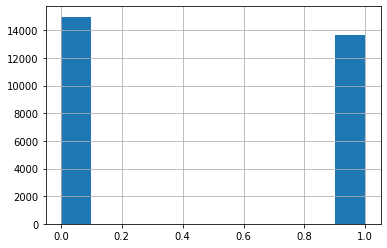

In [3]:
import re
def search_newspaper(x):
    y = re.findall(r"huffingtonpost",x) or re.findall(r"theonion",x)
    return y[0]
    
data['newspaper'] = data['article_link'].apply(search_newspaper)
print('Number of headlines:', data.shape[0])

print(data.groupby(['newspaper','is_sarcastic'])[['headline']].count().rename({'headline':'count'},axis = 1))

## drop newspaper column
data.drop(columns = 'newspaper',axis = 1, inplace = True)

data.is_sarcastic.hist()

### 1.2. Preprocessing
We iterated over a couple of different pre-processing steps. This included only looking at the verb or adjective in a headline, which yielded positive results in one of our midterm projects. Further we implemented a pre-processing function that either conducts POS tagging (including noun, verb, adjective) or entity recognition. In both cases, stop words are removed, urls cleaned out, lemmatisation conducted everything written lower case. Overall, we are looking to reduce the amount of variation in the dataset to generate meaningful statistics. Note that our pre-processing is not guided by theory, but merely by trial and error procedure.

In [55]:
nlp = spacy.load('en_core_web_sm')

def preprocessing(sentence, entity_rec = False, POS_tagging_prep = True):
    """
    Input: A document
    Output: A cleaned, tokenised document
    """
    s_list = []
    # POS_tagging and preprocessing 
    if POS_tagging_prep == True:
         return ' '.join([token.lemma_ for token in nlp(sentence) if (token.pos_ in {'NOUN', 'VERB', 'ADJ', 'ADV', 'X'} and (token.lemma_.lower() != '’s') 
                                                                  and (token.is_stop == False) and (token.is_punct == False) 
                                                                  and (token.like_url == False))])
                
    # Tokenisation / stop-word removal / punctuation removal / url removal
    else:
        spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
        if entity_rec == True:
            s_analysed = nlp(sentence)
            # Entity recognition
            entity = [entity.text for entity in s_analysed.ents]
            for words in entity:
                modified_words = words.replace(" ", "_")
                sentence = sentence.replace(words, modified_words)        
        s_analysed = nlp(sentence.replace("’s", "")) # removal of ’s before tokenisation 
        for token in s_analysed:
            if (token.is_stop == False) and (token.is_punct == False) and (token.like_url == False):
                s_list.append(token.lemma_.lower())
    return s_list

In [21]:
data['cleaned'] = data.headline.apply(preprocessing, entity_rec = True)
data.drop("article_link", axis = 1, inplace = True)

data['Set'] = np.random.choice(
    ['train', 'valid', 'test'],
    data.shape[0],
    p=[0.7, 0.15, 0.15]
)

In [22]:
#data.to_csv('cleaned_data.csv')

### 1.3. Import cleaned data

In [4]:
data = pd.read_csv("cleaned_data.csv")
data.drop('Unnamed: 0',axis = 1,inplace = True)
data.cleaned.dropna(axis = 0,inplace= True) ## Not deleting rows to get the right statistics at next section
data.head()

,is_sarcastic,headline,cleaned,Set
0,1,thirtysomething scientists unveil doomsday clo...,thirtysomething scientist hair loss,train
1,0,dem rep. totally nails why congress is falling...,totally nail fall short gender racial equality,train
2,0,eat your veggies: 9 deliciously different recipes,eat veggie deliciously different recipe,train
3,1,inclement weather prevents liar from getting t...,inclement weather prevent liar get work,train
4,1,mother comes pretty close to using word 'strea...,mother come pretty close word streaming correctly,test


### 1.4. Comparison BEFORE and AFTER preprocessing

In [5]:
## SOME STATISTICS
## headline tokens 
headline_tokens = [headline.split() for headline in list(data.headline)]

# Number of tokens
all_headline_tokens = [inner for outer in headline_tokens for inner in outer]
num_headline_tokens = len(all_headline_tokens)
# Number of types
num_headline_types = len(set(all_headline_tokens))

## cleaned headline tokens
cleaned_tokens = [headline.split() for headline in list(data.cleaned)]
# Number of tokens
all_cleaned_tokens = [inner for outer in cleaned_tokens for inner in outer]
num_cleaned_tokens = len(all_cleaned_tokens)
# Number of types
num_cleaned_types = len(set(all_cleaned_tokens))

number_documents = [0 for i in range(2)]
number_types = [0 for i in range(2)]
number_tokens = [0 for i in range(2)]
number_documents[0] = len(headline_tokens)
number_documents[1] = len(cleaned_tokens)
number_types[0] = num_headline_types
number_types[1] = num_cleaned_types
number_tokens[0] = num_headline_tokens
number_tokens[1] = num_cleaned_tokens

## PREPROCESSING SUMMMARY
Preprocessing_Statistics = pd.DataFrame(data = [number_documents,number_types,number_tokens], index = ['Documents', 'Types', 'Tokens'], columns = ['Before Preprocessing', 'After Preprocessing'])
Preprocessing_Statistics

,Before Preprocessing,After Preprocessing
Documents,28619,28455
Types,38234,14817
Tokens,287620,148735


In [6]:
## drop rows when cleaned column is empty
data.dropna(axis = 0,inplace= True)

### 1.5. Additional analysis
In this section we want to see if there are statistically significant differences between the normal and the sarcastic headlines: particularly we focus on sentence length, average word length, question mark and exclamation mark.

In [7]:
from scipy.stats import ttest_ind
def length(sentence):
    tokens = nltk.word_tokenize(sentence)
    return len(tokens)

def avg_word_length(sentence):
    words = nltk.word_tokenize(sentence)
    avg = sum([len(word) for word in words])/len(words)
    return avg

def question_mark(sentence):
    return sentence.count('?')

def exclamation(sentence):
    return sentence.count('!')

In [8]:
data['sentence_length'] = data.headline.apply(length)
data['avg_word_length'] = data.headline.apply(avg_word_length)
data['exclamation'] = data.headline.apply(exclamation)
data['question_mark'] = data.headline.apply(question_mark)

In [9]:
list_sarcasm = data[data["is_sarcastic"] == 1]['sentence_length'].to_list()
list_normal = data[data["is_sarcastic"] == 0]['sentence_length'].to_list()

print(ttest_ind(list_sarcasm, list_normal))
print("p_value is 1%: the sentence lengths are not statistically different")

Ttest_indResult(statistic=2.384577821712274, pvalue=0.017105241792974006)
p_value is 1%: the sentence lengths are not statistically different


In [10]:
list_sarcasm = data[data["is_sarcastic"] == 1]['avg_word_length'].to_list()
list_normal = data[data["is_sarcastic"] == 0]['avg_word_length'].to_list()

from scipy.stats import ttest_ind

print(ttest_ind(list_sarcasm, list_normal))
print("p_value is 0%: the avg_word_length length are not statistically different")

Ttest_indResult(statistic=40.98539829209385, pvalue=0.0)
p_value is 0%: the avg_word_length length are not statistically different


In [11]:
list_sarcasm = data[data["is_sarcastic"] == 1]['exclamation'].to_list()
list_normal = data[data["is_sarcastic"] == 0]['exclamation'].to_list()

from scipy.stats import ttest_ind

print(ttest_ind(list_sarcasm, list_normal))
print("p_value is 0%: the number of exclamation are not statistically different")

Ttest_indResult(statistic=-7.9320860087451415, pvalue=2.2335583795112354e-15)
p_value is 0%: the number of exclamation are not statistically different


In [12]:
list_sarcasm = data[data["is_sarcastic"] == 1]['question_mark'].to_list()
list_normal = data[data["is_sarcastic"] == 0]['question_mark'].to_list()

from scipy.stats import ttest_ind

print(ttest_ind(list_sarcasm, list_normal))
print("p_value is 0%: the number of question_mark  are not statistically different")

Ttest_indResult(statistic=-20.37120239833513, pvalue=1.357719813453224e-91)
p_value is 0%: the number of question_mark  are not statistically different


**Results**: there are no statistically significant differences between the features we examined. Hence, we do not encode those into the dataset and proceed with the analysis.

#### 1.5.1. Text visualization
Here we want to find out whether we can see a difference in the relative amount of nouns, verbs, adjectives, etc. used, analysing their relative frequency in sarcastic and not sarcastic headlines.

In [13]:
nlp = spacy.load('en_core_web_sm')

def pos(text):
    return ' '.join([token.pos_ for token in nlp(text)])

# Add new column with parts of speech of each headline
data['review_pos'] = data.cleaned.apply(pos)

In [14]:
pos_sarcasm = data.loc[data.is_sarcastic == 1, ["review_pos"]]
pos_normal = data.loc[data.is_sarcastic == 0, ["review_pos"]]

In [15]:
pos_sarcasm = pos_sarcasm.astype(str)
pos_normal = pos_normal.astype(str)

In [16]:
# Reset the indices of the distinct sarcastic and not sarcastic headline dataframes
pos_sarcasm.reset_index(drop=True, inplace = True)
pos_normal.reset_index(drop=True, inplace = True)

# Sarcastic - make list of dictionaries for fraction of times the type of word appears in headline
dict_list = []
for i in range(pos_sarcasm.shape[0]):
    temp_list = pos_sarcasm.review_pos[i].split()
    temp_dict = dict(Counter(temp_list))
    for j in temp_dict:
        temp_dict[j] = temp_dict[j] / len(temp_list)
    dict_list.append(temp_dict)

# Make lists for how often each word type appears across the different headlines
relevant_word_types = ['VERB','ADV', 'ADJ', 'PROPN', 'NOUN', 'PRON']
word_type_frequencies_pos = {k: [] for k in relevant_word_types}


for word_type in relevant_word_types:
    for i in range(len(dict_list)):
        if word_type in dict_list[i]:
            word_type_frequencies_pos[word_type].append(dict_list[i][word_type])

# Normal - make list of dictionaries for fraction of times the type of word appears in headline
dict_list = []
for i in range(pos_normal.shape[0]):
    temp_list = pos_normal.review_pos[i].split()
    temp_dict = dict(Counter(temp_list))
    for j in temp_dict:
        temp_dict[j] = temp_dict[j] / len(temp_list)
    dict_list.append(temp_dict)
    
# Make lists for how often each word type appears across the different headlines
relevant_word_types = ['VERB','ADV', 'ADJ', 'PROPN', 'NOUN', 'PRON']
word_type_frequencies_neg = {k: [] for k in relevant_word_types}


for word_type in relevant_word_types:
    for i in range(len(dict_list)):
        if word_type in dict_list[i]:
            word_type_frequencies_neg[word_type].append(dict_list[i][word_type])

In [17]:
relevant_word_types

['VERB', 'ADV', 'ADJ', 'PROPN', 'NOUN', 'PRON']

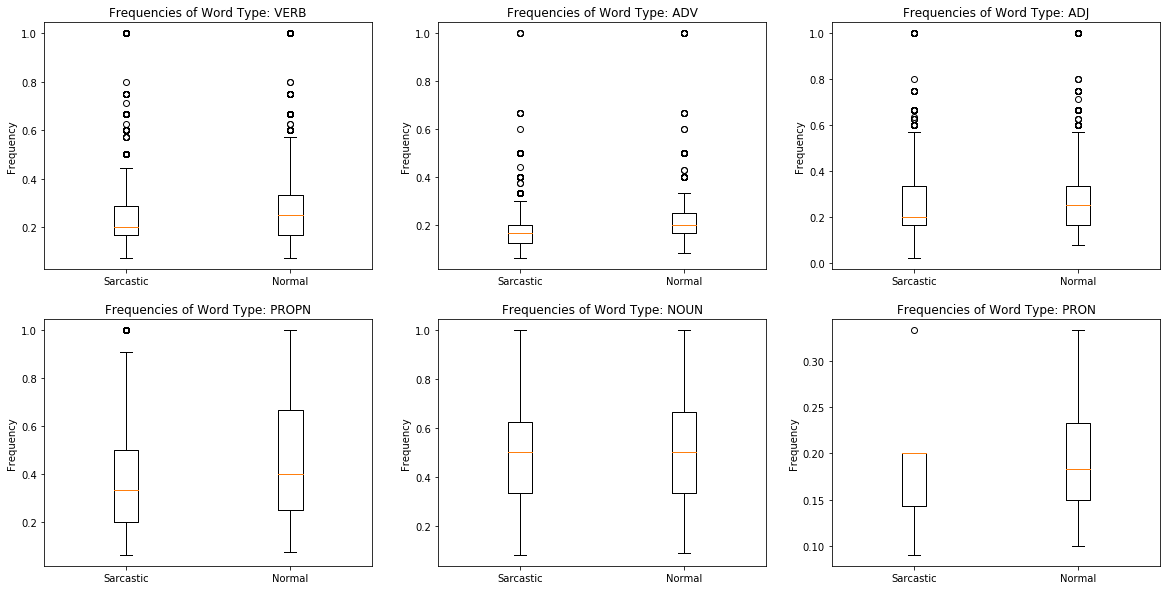

In [18]:
fig, axs = plt.subplots(2, 3)
fig.set_figheight(10)
fig.set_figwidth(20)
for i in [0,1]:
    for j in [0,1,2]:
        axs[i][j].boxplot([word_type_frequencies_pos[relevant_word_types[j+i*(len(relevant_word_types)//2)]], word_type_frequencies_neg[relevant_word_types[j+i*(len(relevant_word_types)//2)]]])
        axs[i][j].set_title('Frequencies of Word Type: %s' %relevant_word_types[j+i*(len(relevant_word_types)//2)])
        axs[i][j].set_ylabel('Frequency')
        axs[i][j].set_xticklabels(['Sarcastic', 'Normal'])

Looking at various frequencies of word types, we see some differences between sarcastic and non-sarcastic headlines. For example, sarcastic headlines have a lower frequency of verbs and adjectives. Further, there seems to be a different distribution of pronouns between sarcastic and non-sarcastic headlines.

## 2. Research Question(s)

### **Report: Amazon Using Heat-Sensing Alien Hunters To Track Workers Attempting To Unionize**

#### **Now, is this a sarcastic headline or not? We are interested in developing an algorithm that is able to detect sarcasm. While this remains an active research area and is considered one of the toughest challenges in NLP (https://link.springer.com/article/10.1007/s10462-019-09791-8?shared-article-renderer), we are confident in tackling this issue by examining the underlying topics, document embeddings and developing a language model. On this basis, we develop a prediction machine.**

In [19]:
sarcasm = data.loc[((data["is_sarcastic"] == 1) & (data["Set"]== 'train')),["headline","cleaned"]]
normal = data.loc[((data["is_sarcastic"] == 0) & (data["Set"]== 'train')),["headline","cleaned"]]

### Most important words

Most frequent words in sarcastic headlines:

In [20]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word', 
                             min_df=0.01,
                             max_df=0.6, 
                             stop_words='english')
X = tfidf_vectorizer.fit_transform(sarcasm.cleaned.dropna().tolist())

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer='word', min_df=0.01, max_df=0.6, stop_words='english')

X2 = vectorizer.fit_transform(sarcasm.cleaned.dropna().tolist())

df = pd.DataFrame(data={'word': vectorizer.get_feature_names(), 
                        'tf': X2.sum(axis=0).A1, 
                        'idf': tfidf_vectorizer.idf_,
                        'tfidf': X.sum(axis=0).A1
                       })
print("Sarcasm Words")
df = df.sort_values(['tfidf', 'tf', 'idf'], ascending = False).reset_index(drop = True)
df.head()

Sarcasm Words


,word,tf,idf,tfidf
0,man,701,3.616149,519.920290
1,new,533,3.891946,442.811526
2,report,400,4.171470,323.933275
3,woman,334,4.369921,257.521853
4,nation,255,4.621671,206.399959


Most frequent words in not sarcastic headlines:

In [21]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word', 
                             min_df=0.01, 
                             max_df=0.6, 
                             stop_words='english')
X = tfidf_vectorizer.fit_transform(normal.cleaned.dropna().tolist()) #I use the title to get the topic
vectorizer = CountVectorizer(analyzer='word', min_df=0.01, max_df=0.6, stop_words='english')

X2 = vectorizer.fit_transform(normal.cleaned.dropna().tolist())

df = pd.DataFrame(data={'word': vectorizer.get_feature_names(), 
                        'tf': X2.sum(axis=0).A1, 
                        'idf': tfidf_vectorizer.idf_,
                        'tfidf': X.sum(axis=0).A1
                       })
print("Normal")
df = df.sort_values(['tfidf', 'tf', 'idf'], ascending = False).reset_index(drop = True)
df.head()

Normal


,word,tf,idf,tfidf
0,trump,345,4.407266,296.906229
1,new,335,4.448692,280.008659
2,woman,326,4.488759,266.448487
3,say,278,4.626793,238.020371
4,man,234,4.795489,185.999156


**Results**: the most frequent words between sarcastic and normal headlines are very similar so sarcasm is not differentiated by them.

### 3.1. LDA topic model
We run LDA model for sarcastic and not sarcastic headlines separately to see if they differentiate by topics.

In [22]:
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.corpora import Dictionary
import time
import multiprocessing
import random
import re

#### 3.1.1. LDA on sarcastic headlines

In [23]:
# get dictionary
instances = sarcasm.cleaned.dropna().apply(str.split)
print("creating dictionary", flush=True)
# read in instances and create Dictionary object w information about frequencies etc. 
dictionary = Dictionary(instances)
# get rid of words that are too rare or too frequent
dictionary.filter_extremes(no_below=100, no_above=0.3) #we restrict ousrlef with words that occur more than 50 times, and words that occur below 30% of the documents. 
print(dictionary, flush=True)

creating dictionary
Dictionary(42 unique tokens: ['get', 'work', 'come', 'make', 'new']...)


In [24]:
#replace words by their numerical IDs and their frequency
print("translating corpus to IDs", flush=True)
ldacorpus = [dictionary.doc2bow(text) for text in instances] #replace each words by its id in our vocabulary, list of list of integers
# learn TFIDF values from corpus
print("tf-idf transformation", flush=True)
tfidfmodel = TfidfModel(ldacorpus)
# transform raw frequencies into TFIDF
model_corpus = tfidfmodel[ldacorpus]

translating corpus to IDs
tf-idf transformation


##### Choosing number of topics
The best number of topics for the sarcastic headlines is 5:

In [16]:
coherence_values = []
model_list = []

dev_size = 5000
eval_size = 1000

random.seed(42)
for num_topics in range(4, 10):
    model = LdaMulticore(corpus=model_corpus[:dev_size], 
                         id2word=dictionary, 
                         workers=min(10, multiprocessing.cpu_count()-1),
                         num_topics=num_topics)

    coherencemodel_umass = CoherenceModel(model=model, 
                                          texts=instances[dev_size:dev_size+eval_size], 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    umass_score = coherencemodel_umass.get_coherence()
    coherence_values.append((num_topics, umass_score))
    
scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass'])

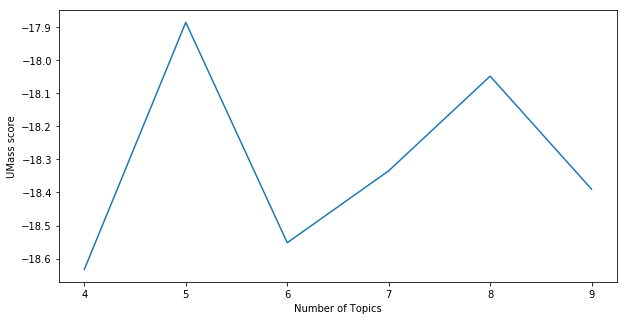

In [17]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(scores.num_topics, scores.UMass)
plt.xlabel('Number of Topics')
plt.ylabel('UMass score')
plt.show()

In [25]:
num_topics = 5

# find chunksize to make about 200 updates
num_passes = 10
chunk_size = len(model_corpus) * num_passes/200
print(chunk_size)

start = time.time()
print("fitting model", flush=True)
model = LdaMulticore(num_topics=num_topics, # number of topics
                     corpus=model_corpus, # what to train on 
                     id2word=dictionary, # mapping from IDs to words
                     workers=min(10, multiprocessing.cpu_count()-1), # choose 10 cores, or whatever computer has
                     passes=num_passes, # make this many passes over data
                     chunksize=chunk_size, # update after this many instances
                     alpha=0.5 #controls how many topics we expcet to see in a document. if alpha is big we expect to see all topics in one document, large alpha is 100
                    )
    
print("done in {}".format(time.time()-start), flush=True)

476.8
fitting model
done in 4.503127098083496


In [26]:
# get the topic descritions
topic_sep = re.compile(r"0\.[0-9]{3}\*") # getting rid of useless formatting
# extract a list of tuples with topic number and descriptors from the model
model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                model.print_topics(num_topics=num_topics, num_words=5)]

# Create a list of list of topics
list_topics = [[0 for j in range(len(model_topics[i][1]))] for i in range(len(model_topics))]
for i in range(len(model_topics)):
    list_topics[i][0] = model_topics[i][1][0].replace('"','')
    j = 1
    for j in range(len(model_topics[i][1])):
        list_topics[i][j]= model_topics[i][1][j].replace('"','')
        j +=1
# Create a dataframe for better visualization
df_topics_gensim = pd.DataFrame(data = list_topics).T 
df_topics_gensim.columns = ['Topic '+str(i) for i in range(len(list_topics))]
df_topics_gensim

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4
0,day,get,report,man,woman
1,area,family,time,new,old
2,look,good,go,year,find
3,trump,come,work,study,life
4,leave,nation,say,friend,child


#### 3.1.2. LDA on NOT sarcastic headlines

In [27]:
# get dictionary
# run on 50000 instances
instances = normal.cleaned.dropna().apply(str.split)
print("creating dictionary", flush=True)
# read in instances and create Dictionary object w information about frequencies etc. 
dictionary = Dictionary(instances)
# get rid of words that are too rare or too frequent
dictionary.filter_extremes(no_below=100, no_above=0.3) #we restrict ousrlef with words that occur more than 50 times, and words that occur below 30% of the documents. 
print(dictionary, flush=True)

creating dictionary
Dictionary(45 unique tokens: ['way', 'know', 'tell', 'kill', 'look']...)


In [28]:
#replace words by their numerical IDs and their frequency
print("translating corpus to IDs", flush=True)
ldacorpus = [dictionary.doc2bow(text) for text in instances] #replace each words by its id in our vocabulary, list of list of integers
# learn TFIDF values from corpus
print("tf-idf transformation", flush=True)
tfidfmodel = TfidfModel(ldacorpus)
# transform raw frequencies into TFIDF
model_corpus = tfidfmodel[ldacorpus]

translating corpus to IDs
tf-idf transformation


##### Choosing number of topics
The best number of topics for the normal headlines is 8:

In [ ]:
coherence_values = []
model_list = []

dev_size = 5000
eval_size = 1000

random.seed(42)
for num_topics in range(4, 10):
    model = LdaMulticore(corpus=model_corpus[:dev_size], 
                         id2word=dictionary, 
                         workers=min(10, multiprocessing.cpu_count()-1),
                         num_topics=num_topics)

    coherencemodel_umass = CoherenceModel(model=model, 
                                          texts=instances[dev_size:dev_size+eval_size], 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    umass_score = coherencemodel_umass.get_coherence()
    coherence_values.append((num_topics, umass_score))
    
scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass'])

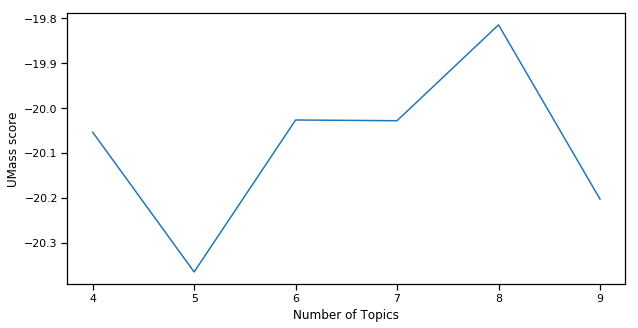

In [66]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(scores.num_topics, scores.UMass)
plt.xlabel('Number of Topics')
plt.ylabel('UMass score')
plt.show()

In [29]:
num_topics = 8

# find chunksize to make about 200 updates
num_passes = 10
chunk_size = len(model_corpus) * num_passes/200
print(chunk_size)

start = time.time()
print("fitting model", flush=True)
model = LdaMulticore(num_topics=num_topics, # number of topics
                     corpus=model_corpus, # what to train on 
                     id2word=dictionary, # mapping from IDs to words
                     workers=min(10, multiprocessing.cpu_count()-1), # choose 10 cores, or whatever computer has
                     passes=num_passes, # make this many passes over data
                     chunksize=chunk_size, # update after this many instances
                     alpha=0.5 #controls how many topics we expcet to see in a document. if alpha is big we expect to see all topics in one document, large alpha is 100
                    )
    
print("done in {}".format(time.time()-start), flush=True)

520.6
fitting model
done in 4.492825031280518


In [30]:
# get the topic descritions
topic_sep = re.compile(r"0\.[0-9]{3}\*") # getting rid of useless formatting
# extract a list of tuples with topic number and descriptors from the model
model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                model.print_topics(num_topics=num_topics, num_words=5)]

# Create a list of list of topics
list_topics = [[0 for j in range(len(model_topics[i][1]))] for i in range(len(model_topics))]
for i in range(len(model_topics)):
    list_topics[i][0] = model_topics[i][1][0].replace('"','')
    j = 1
    for j in range(len(model_topics[i][1])):
        list_topics[i][j]= model_topics[i][1][j].replace('"','')
        j +=1
# Create a dataframe for better visualization
df_topics_gensim = pd.DataFrame(data = list_topics).T 
df_topics_gensim.columns = ['Topic '+str(i) for i in range(len(list_topics))]
df_topics_gensim

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7
0,man,year,say,woman,people,trump,new,day
1,get,talk,way,thing,look,want,good,life
2,watch,video,change,black,kid,find,year,love
3,know,school,time,need,health,call,woman,help
4,right,way,come,attack,win,go,way,big


**Results**: sarcasm doesn't differentiate itself by topics.

### 3.2. Dense document embeddings

In [88]:
d2v_model = D2VTransformer(size=100, min_count=1, workers=6)
d2v_data = d2v_model.fit_transform(data.cleaned.apply(str.split).tolist())

In [89]:
tsne_d2v = TSNE(n_components=2, verbose = 1, random_state = 42).fit_transform(d2v_data)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 28455 samples in 0.276s...
[t-SNE] Computed neighbors for 28455 samples in 83.671s...
[t-SNE] Computed conditional probabilities for sample 1000 / 28455
[t-SNE] Computed conditional probabilities for sample 2000 / 28455
[t-SNE] Computed conditional probabilities for sample 3000 / 28455
[t-SNE] Computed conditional probabilities for sample 4000 / 28455
[t-SNE] Computed conditional probabilities for sample 5000 / 28455
[t-SNE] Computed conditional probabilities for sample 6000 / 28455
[t-SNE] Computed conditional probabilities for sample 7000 / 28455
[t-SNE] Computed conditional probabilities for sample 8000 / 28455
[t-SNE] Computed conditional probabilities for sample 9000 / 28455
[t-SNE] Computed conditional probabilities for sample 10000 / 28455
[t-SNE] Computed conditional probabilities for sample 11000 / 28455
[t-SNE] Computed conditional probabilities for sample 12000 / 28455
[t-SNE] Computed conditional probabilities for sa

In [94]:
tfidf = TfidfVectorizer(analyzer='word', 
                             min_df=0.01, 
                             max_df=0.75, 
                             stop_words='english')
vector_sample  = tfidf.fit_transform(data.cleaned.tolist())
svd = TruncatedSVD(n_components=2)
low_dim_svd = TruncatedSVD(n_components=2)
low_dim_U = low_dim_svd.fit_transform(vector_sample)

Text(0.5, 1.0, 'T-SNE Decomposition')

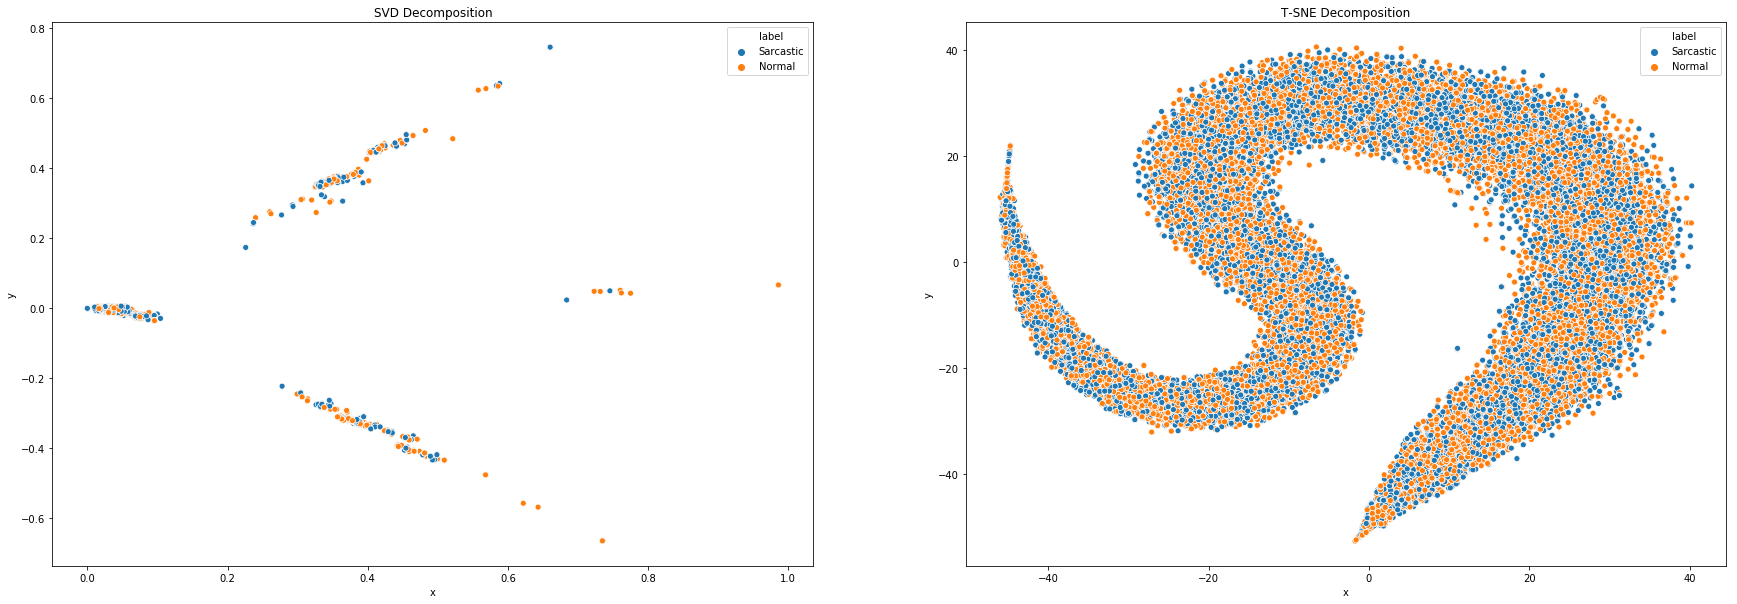

In [95]:
svd_data = pd.DataFrame(low_dim_U, columns = ['x','y'])
svd_data['label'] = data.is_sarcastic.replace({0 : 'Normal', 1 : 'Sarcastic'})
tsne_d2v_df = pd.DataFrame(data=tsne_d2v, columns=["x", "y"])
tsne_d2v_df['label'] = data.is_sarcastic.replace({0 : 'Normal', 1 : 'Sarcastic'})

plt.figure(figsize = (30, 10))
ax = plt.subplot(1,2,1)
seaborn.scatterplot('x', 'y', data=svd_data, hue='label', ax=ax)
ax.set_title('SVD Decomposition')
ax = plt.subplot(1,2,2)
seaborn.scatterplot('x', 'y', data=tsne_d2v_df, hue='label',ax=ax)
ax.set_title('T-SNE Decomposition')

**Results**: it's not trivial to differentiate between the two groups.

### Clustering
We are interested in understanding how the sarcasm and non-sarcasm headlines are distributed on two clusters.

In [28]:
## PLOT FUNCTION
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
import seaborn as sb

sb.set_context('notebook')

def plot_vectors(vectors, title='VIZ', labels=None, dimensions=3):
    """
    plot the vectors in 2 or 3 dimensions. 
    If labels are supplied, use them to color the data accordingly
    """
    # set up graph
    fig = plt.figure(figsize=(10,10))

    # create data frame
    df = pd.DataFrame(data={'x':vectors[:,0], 'y': vectors[:,1]})
    # add labels, if supplied
    if labels is not None:
        df['label'] = labels
    else:
        df['label'] = [''] * len(df)

    # assign colors to labels
    cm = plt.get_cmap('afmhot') # choose the color palette
    n_labels = len(df.label.unique())
    label_colors = [cm(1. * i/n_labels) for i in range(n_labels)] #we discretisize the color gradient to labels components
    cMap = colors.ListedColormap(label_colors)
        
    # plot in 3 dimensions
    if dimensions == 3:
        # add z-axis information
        df['z'] = vectors[:,2]
        # define plot
        ax = fig.add_subplot(111, projection='3d')
        frame1 = plt.gca() 
        # remove axis ticks
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])
        frame1.axes.zaxis.set_ticklabels([])

        # plot each label as scatter plot in its own color
        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], df2['z'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor=None, 
                       label=label, 
                       alpha=0.4, 
                       s=100)
      
    # plot in 2 dimensions
    elif dimensions == 2:
        ax = fig.add_subplot(111)
        frame1 = plt.gca() 
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])

        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor=None, 
                       label=label, 
                       alpha=0.4, 
                       s=100)

    else:
        raise NotImplementedError()

    plt.title(title)
#     plt.legend()
    plt.show()

CPU times: user 11.2 s, sys: 779 ms, total: 12 s
Wall time: 2 s
CPU times: user 7.63 s, sys: 164 ms, total: 7.79 s
Wall time: 6.87 s


/home/hugopao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  """Entry point for launching an IPython kernel.


CPU times: user 1.05 s, sys: 7.63 ms, total: 1.05 s
Wall time: 316 ms


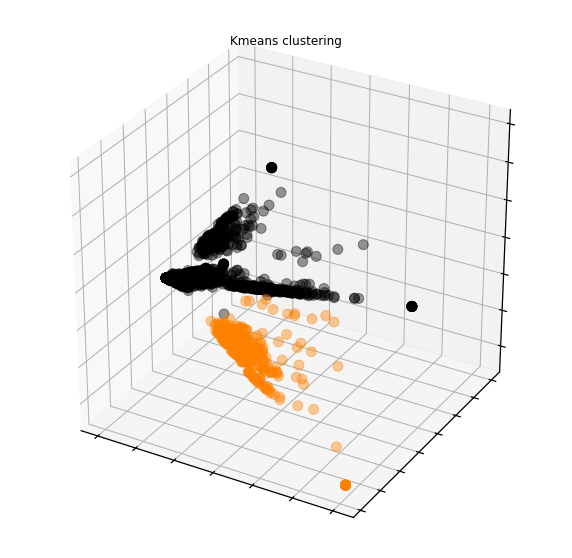

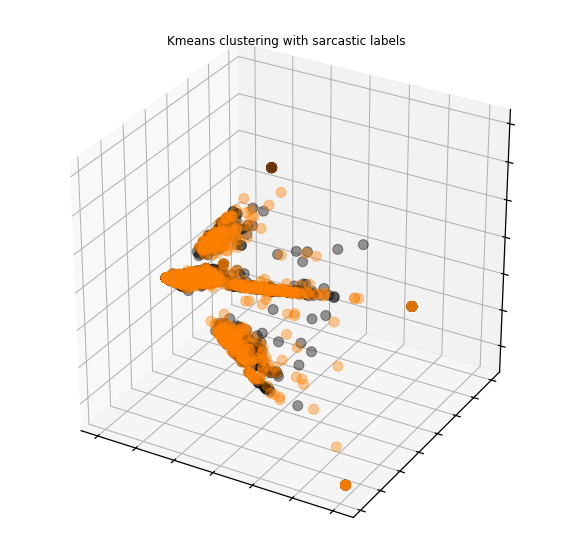

In [46]:
from sklearn.cluster import KMeans, AgglomerativeClustering

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), 
                                   stop_words='english', 
                                   analyzer='word', 
                                   min_df=0.001, 
                                   max_df=0.7, 
                                   sublinear_tf=True, 
                                   use_idf=True)

X = tfidf_vectorizer.fit_transform(data.cleaned.tolist())


k = 2

# reduce the dimensionality of the input, to speed up clustering
%time X2 = TruncatedSVD(n_components=300).fit_transform(X)

agg = AgglomerativeClustering(n_clusters=k)

%time agg_sample_ids = agg.fit_predict(X2[:8000])
centroids = np.array([X2[:8000][agg_sample_ids == c].mean(axis=0) for c in range(k)])
km = KMeans(n_clusters=k, 
            n_jobs=-1, 
            init=centroids)

# fit it on the full 300-dimensional data set
%time km.fit(X2[:8000])

plot_vectors(X2[:8000], title = 'Kmeans clustering',labels=km.labels_)
plot_vectors(X2[:8000], title = 'Kmeans clustering with sarcastic labels',labels = data.is_sarcastic[:8000])

In [47]:
from sklearn.metrics import accuracy_score
print("accuracy of k_means : ", accuracy_score(km.labels_, data.is_sarcastic[:8000]))

accuracy of k_means :  0.51525


**Results**: the accuracy measure is around 50% signalling that the clusters do not correspond to a sarcasm / non-sarcasm split.

## 4. Prediction (15 pts)


### 4.1 Classification (9 pts)
Build a predictive model of the target label and use appropriate performance metrics. Your predictive analysis needs to involve **all** of the following, summarized in a table:

1. a most-frequent-label baseline (1 point)
2. a `LogisticRegression()` baseline with default parameters and 2-6 gram character TFIDF features (1 pt)
3. the performance of **at least** two more predictive model architecture (2 pts each), including description/justification of the optmization steps taken (2 pts).
4. two bootstrap sampling significance tests of the performance difference between your best model and each of the two baselines (1 pts)

NB: Do make sure that the optimization steps are done on the development split and do *not* include the test split! Training on the test set will be graded 0!

In [31]:
X_train = data.loc[data.Set =='train', ["cleaned"]]
y_train = data.loc[data.Set =='train', ["is_sarcastic"]]

X_valid = data.loc[data.Set =='valid', ["cleaned"]]
y_valid = data.loc[data.Set =='valid', ["is_sarcastic"]]

X_test = data.loc[data.Set =='test', ["cleaned"]]
y_test = data.loc[data.Set =='test', ["is_sarcastic"]]

#### 4.1.1. Most-Frequent-Label baseline
The Dummy Classifier gives a measure of baseline performance since it returns a sort of success rate one should expect by simply guessing: in this case it considers the most frequent label in the headlines which is "not sarcastic".

In [33]:
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier

most_frequent = DummyClassifier(strategy='most_frequent')
most_frequent.fit(X_train, y_train)
dumb_predictions = most_frequent.predict(X_test)

print(classification_report(y_test, dumb_predictions))

              precision    recall  f1-score   support

           0       0.52      1.00      0.68      2163
           1       0.00      0.00      0.00      2028

    accuracy                           0.52      4191
   macro avg       0.26      0.50      0.34      4191
weighted avg       0.27      0.52      0.35      4191



#### 4.1.2. Logistic-Regression baseline
In classification problems the logistic regression results a good measure of baseline performance since it is a simple generalized linear model that runs quickly and gives a first look at the accuracy improvement gap: our purpose is to beat this baseline, if possible.

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(2,6), 
                             analyzer='char')

X_train = data.loc[data.Set =='train', ["cleaned"]]
X_valid = data.loc[data.Set =='valid', ["cleaned"]]
X_test = data.loc[data.Set =='test', ["cleaned"]]

X_train = vectorizer.fit_transform(X_train.cleaned.tolist())
X_valid = vectorizer.transform(X_valid.cleaned.tolist())
X_test = vectorizer.transform(X_test.cleaned.tolist())

In [35]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(n_jobs=-1, multi_class='auto', solver = 'lbfgs')
%time classifier.fit(X_train, y_train.values.ravel())
print(classifier)

CPU times: user 75.3 ms, sys: 155 ms, total: 231 ms
Wall time: 7.02 s
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [36]:
predictions = classifier.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.73      0.79      0.76      2163
           1       0.76      0.69      0.72      2028

    accuracy                           0.74      4191
   macro avg       0.74      0.74      0.74      4191
weighted avg       0.74      0.74      0.74      4191



Logistic-Regression adding the balanced option to treat the sarcastic and not sarcastic headlines with the same importance.

In [37]:
classifier_balanced = LogisticRegression(n_jobs=-1, multi_class='auto', solver='lbfgs', 
                                         class_weight='balanced')
%time classifier_balanced.fit(X_train, y_train.values.ravel())
predictions_balanced = classifier_balanced.predict(X_test)

print(classification_report(y_test, predictions_balanced))

CPU times: user 382 ms, sys: 70.7 ms, total: 453 ms
Wall time: 5.32 s
              precision    recall  f1-score   support

           0       0.75      0.76      0.76      2163
           1       0.74      0.73      0.74      2028

    accuracy                           0.75      4191
   macro avg       0.75      0.75      0.75      4191
weighted avg       0.75      0.75      0.75      4191



#### 4.1.3.1. Naive Bayes Classifier
We implement Naive Bayes Classifier because in practise it works pretty well; moreover, it is easy to implement, fast on huge amout of data and parallelizes well. We have tried to tune the parameters through trial and error but the best result we got has been with the default parameters (alpha = 1, fit_prior = True): with alpha less or greater than 1 the accuray decreases (the optimization has been done on validation set).

In [48]:
from sklearn import model_selection, naive_bayes
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(X_train,y_train.values.ravel())
# predict the labels on test dataset
predictions_NB = Naive.predict(X_test)
# Use classification_report function to get the accuracy
print(classification_report(y_test, predictions_NB))

              precision    recall  f1-score   support

           0       0.73      0.76      0.74      2163
           1       0.73      0.70      0.71      2028

    accuracy                           0.73      4191
   macro avg       0.73      0.73      0.73      4191
weighted avg       0.73      0.73      0.73      4191



#### 4.1.3.2. Support Vector Machines
SVM is another algorithm that usually in classification problem performs well: the main problem is that if the amount of data is big, it is very slow because it can not be parallelized. The following parameters have been chosen through trials and errors tuning on the valid set:

In [49]:
from sklearn import model_selection, svm
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel = 'linear', gamma='auto')
SVM.fit(X_train,y_train.values.ravel())
# predict the labels on validation dataset
predictions_SVM = SVM.predict(X_valid)
print(classification_report(y_valid, predictions_SVM))

              precision    recall  f1-score   support

           0       0.77      0.78      0.77      2285
           1       0.75      0.74      0.74      2031

    accuracy                           0.76      4316
   macro avg       0.76      0.76      0.76      4316
weighted avg       0.76      0.76      0.76      4316



We have tried other kernel configurations and lower and greater values of C but in all the cases we got worst results than simply using the linear kernel with default C.

In [50]:
# predict the labels on test dataset
predictions_SVM = SVM.predict(X_test)
print(classification_report(y_test, predictions_SVM))

              precision    recall  f1-score   support

           0       0.75      0.78      0.76      2163
           1       0.76      0.72      0.74      2028

    accuracy                           0.75      4191
   macro avg       0.75      0.75      0.75      4191
weighted avg       0.75      0.75      0.75      4191



#### 4.1.3.3. XGBoost Classifier
XGBoost has been chosen because it is a decision-tree ensemble machine learning model that uses an optimized gradient boosting framework which often outperforms all other algorithms.

First we have run with default parameters to see how it generally performs:

In [152]:
import xgboost
clf = xgboost.XGBClassifier(n_estimators = 1000, n_jobs = 4)
clf.fit(X_train, y_train.values.ravel())
predictions_boost = clf.predict(X_valid)
print(classification_report(y_valid, predictions_boost))

              precision    recall  f1-score   support

           0       0.73      0.78      0.75      2313
           1       0.72      0.66      0.69      1988

    accuracy                           0.73      4301
   macro avg       0.73      0.72      0.72      4301
weighted avg       0.73      0.73      0.73      4301



Then we have tuned the parameters with GridSearchCV. The result is not printed because, due to the huge computational demand, it has been run on GCP and still with few parameters. The results are:
- 'learning_rates' = 0.001
- 'max_depth' = 3
- 'min_child_weight' = 1

In [ ]:
## XGBOOST TUNING PARAMETERS
#clf = xgboost.XGBClassifier(n_estimators = 1000, n_jobs = 16)

#print("fitting grid search")
#params = {
#         'min_child_weight': [1, 5, 10],
#         'max_depth': [3, 4, 5],
#         'learning_rates' : [0.001, 0.01, 0.1]
#         }

#grid_search = GridSearchCV(clf, params, cv = 5, scoring = "accuracy", n_jobs = 16)
#grid_search.fit(X_train,y_train)
#print(grid_search.best_params_)

The tuning of the parameters didn't improve the performance on valid set, still 73% accuracy. Here the results on test set with the tuned values:

In [155]:
clf = xgboost.XGBClassifier(n_estimators = 1000, learning_rates = 0.001, max_depth = 3, min_child_weight =1, n_jobs = 4, verbose = 1)
clf.fit(X_train, y_train.values.ravel())
predictions_boost = clf.predict(X_test)
print(classification_report(y_test, predictions_boost))

              precision    recall  f1-score   support

           0       0.71      0.79      0.75      2223
           1       0.74      0.65      0.70      2061

    accuracy                           0.72      4284
   macro avg       0.73      0.72      0.72      4284
weighted avg       0.73      0.72      0.72      4284



#### 4.1.3.4. FeedForward Neural Nets
MLP is one of the simplest neural networks algorithm which is often used in classification problems.

In [162]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential

model = Sequential()
model.add(Dense(128, input_dim = X_train.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(256, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 32
epochs = 1
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data = (X_valid, y_valid))

Train on 19870 samples, validate on 4301 samples
Epoch 1/1
19870/19870 [==============================] - 347s 17ms/step - loss: 0.5623 - accuracy: 0.7028 - val_loss: 0.5022 - val_accuracy: 0.7484


In [16]:
predictions_deep = (model.predict(X_test)>0.5)
print(classification_report(y_test, predictions_deep))

              precision    recall  f1-score   support

           0       0.73      0.79      0.76      2239
           1       0.76      0.68      0.72      2097

    accuracy                           0.74      4336
   macro avg       0.74      0.74      0.74      4336
weighted avg       0.74      0.74      0.74      4336



#### 4.1.3.5. Bi-LSTM
Recurrent Neural Nets can be used not only for language modeling and multi-class text classification but also for binary classification: taking into account the usual performance of this algorithm, we have decided to implement Bi-LSTM to predict the labels of the headlines.

In [125]:
X_train = data.loc[data.Set =='train', ["cleaned"]]
y_train = data.loc[data.Set =='train', ["is_sarcastic"]]

X_valid = data.loc[data.Set =='valid', ["cleaned"]]
y_valid = data.loc[data.Set =='valid', ["is_sarcastic"]]

X_test = data.loc[data.Set =='test', ["cleaned"]]
y_test = data.loc[data.Set =='test', ["is_sarcastic"]]

##### 4.1.3.5.1. Preprocessing
The sentences are converted to list of numbers, each numbers representing a word.

In [126]:
# collect known word tokens and tags
wordset = set()
train_instances = [words for words in X_train.cleaned.apply(str.split)]
for words in train_instances:
    wordset.update(set(words))

# map words and tags into ints
PAD = '-PAD-'
UNK = '-UNK-'
word2int = {word: i + 2 for i, word in enumerate(sorted(wordset))}
word2int[PAD] = 0  # special token for padding
word2int[UNK] = 1  # special token for unknown words

def convert2ints(instances):
    result = []
    for words in instances:
        # replace words with int, 1 for unknown words
        word_ints = [word2int.get(word, 1) for word in words]
        # replace tags with int
        result.append(word_ints)
    return result 

In [127]:
# get some test data
test_instances = [words for words in X_test.cleaned.apply(str.split)]

# apply integer mapping
train_instances_int = convert2ints(train_instances)
test_instances_int = convert2ints(test_instances)

In [128]:
# get some valid data
valid_instances = [words for words in X_valid.cleaned.apply(str.split)]

# apply integer mapping
valid_instance_int = convert2ints(valid_instances)

In [129]:
MAX_LENGTH = int(np.percentile([len(instance) for instance in train_instances_int],95))
MAX_LENGTH

9

In [130]:
# add special padding at the end of every instance, up to MAX_LENGTH
train_sentences = pad_sequences(train_instances_int, maxlen=MAX_LENGTH, padding='post')
test_sentences = pad_sequences(test_instances_int, maxlen=MAX_LENGTH, padding='post')
valid_sentences = pad_sequences(valid_instance_int, maxlen=MAX_LENGTH, padding='post')
print(train_sentences[0])

[11367  9798  5063  6570     0     0     0     0     0]


##### 4.1.3.5.2.  Model
We first tried different architectures to find the right balance between complexity and performance on the validation set. We then noticed the high variance of the model as validation error was increasing from first epoch. We lowered the learning rate and changed the optimizer to adam to get comparable results (with the hulk).

In [131]:
np.random.seed(42)
from keras.optimizers import RMSprop
model_seq = Sequential()
model_seq.add(InputLayer(input_shape=(MAX_LENGTH, ), name="word_IDs"))
model_seq.add(Embedding(len(word2int), 128, mask_zero=True, name='embeddings'))
model_seq.add(Bidirectional(LSTM(128), name='bi-LSTM'))
model_seq.add(Dense(256, name = 'fully_connected1', activation = 'relu'))
model_seq.add(Dropout(0.2, name='dropout'))
model_seq.add(Dense(1, activation = 'sigmoid', name='output'))
model_seq.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embeddings (Embedding)       (None, 9, 128)            1627648   
_________________________________________________________________
bi-LSTM (Bidirectional)      (None, 256)               263168    
_________________________________________________________________
fully_connected1 (Dense)     (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 257       
Total params: 1,956,865
Trainable params: 1,956,865
Non-trainable params: 0
_________________________________________________________________


In [132]:
batch_size = 32
epochs = 5

import keras
# compile the model we have defined above
model_seq.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy']
             )

# run training and capture ouput log
history = model_seq.fit(train_sentences, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data = (valid_sentences, y_valid))

/Users/SimoneSilvestri/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 19948 samples, validate on 4316 samples
Epoch 1/5
19948/19948 [==============================] - 23s 1ms/step - loss: 0.5402 - accuracy: 0.7215 - val_loss: 0.4954 - val_accuracy: 0.7475
Epoch 2/5
19948/19948 [==============================] - 23s 1ms/step - loss: 0.4129 - accuracy: 0.8137 - val_loss: 0.4803 - val_accuracy: 0.7653
Epoch 3/5
19948/19948 [==============================] - 23s 1ms/step - loss: 0.3482 - accuracy: 0.8508 - val_loss: 0.5143 - val_accuracy: 0.7653
Epoch 4/5
19948/19948 [==============================] - 23s 1ms/step - loss: 0.2878 - accuracy: 0.8816 - val_loss: 0.5333 - val_accuracy: 0.7486
Epoch 5/5
19948/19948 [==============================] - 24s 1ms/step - loss: 0.2398 - accuracy: 0.9039 - val_loss: 0.5861 - val_accuracy: 0.7437


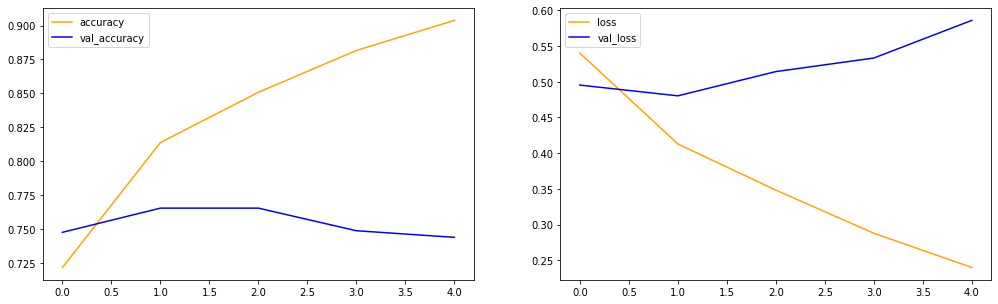

In [148]:
df = pd.DataFrame(history.history)

fig, axs = plt.subplots(nrows=1, ncols=2, facecolor='w', figsize=(17,5))
ax = axs[0]
ax.plot(df['accuracy'],color = 'orange', label = 'accuracy')
ax.plot(df['val_accuracy'], color = 'blue', label = 'val_accuracy')
ax.legend()

ax = axs[1]
ax.plot(df['loss'],color = 'orange', label = 'loss')
ax.plot(df['val_loss'], color = 'blue', label = 'val_loss')
ax.legend()

plt.show()

In [122]:
## Calculated with 2 ephoc
loss, accuracy = model_seq.evaluate(test_sentences, y_test,
                       batch_size=batch_size, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

4191/4191 [==============================] - 1s 168us/step
Test loss: 0.4891617294286265
Test accuracy: 0.7633023262023926


In [123]:
predictions_LSTM = (model_seq.predict(test_sentences)>0.5)
print(classification_report(y_test, predictions_LSTM))

              precision    recall  f1-score   support

           0       0.73      0.85      0.79      2163
           1       0.81      0.67      0.73      2028

    accuracy                           0.76      4191
   macro avg       0.77      0.76      0.76      4191
weighted avg       0.77      0.76      0.76      4191



#### 4.1.3.6. CNN
Convolutional Neural Nets is perfectly in line with our purpose since we need a way to take an arbitrarily long sequence of words as input (headlines) and produce an output (sarcastic or not sarcastic).
First we tried different architecture and kept the one with the best validation score. We then noticed that there was a high variance, so we reduce complexity of the model, the learning rate and the batch size. We finally get comparable results with CNN than we had with the other models we tried (around 75% acc).

In [66]:
np.random.seed(42)

# set parameters of matrices and convolution
embedding_dim = 128
nb_filter = 64
filter_length = 3
hidden_dims = 128


inputs = Input((MAX_LENGTH, ), 
               name='word_IDs')
embeddings = Embedding(len(word2int), 
                       embedding_dim, 
                       input_length=MAX_LENGTH)(inputs)
convolution = Conv1D(filters=nb_filter,  # Number of filters to use
                    kernel_size=filter_length, # n-gram range of each filter.
                    padding='same',  #valid: don't go off edge; same: use padding before applying filter
                    activation='relu',
                    strides=1)(embeddings)
convolution2 = Activation(activation='tanh')(convolution)
pooling = GlobalMaxPooling1D()(convolution2)
dropout1 = Dropout(0.2)(pooling)
dense = Dense(32, activation='relu')(dropout1)
dropout2 = Dropout(0.2)(dense)
output = Dense(1, activation='sigmoid')(dropout2)

model = Model(inputs=[inputs], outputs=[output])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_IDs (InputLayer)        (None, 9)                 0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 9, 128)            1627648   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 9, 64)             24640     
_________________________________________________________________
activation_1 (Activation)    (None, 9, 64)             0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080

In [67]:
batch_size = 32
epochs = 5
CUDA_VISIBLE_DEVICES=""
import keras
adam = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
# compile the model we have defined above
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy']
             )

# run training and capture ouput log
history = model.fit(train_sentences, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data = (valid_sentences, y_valid))

/Users/SimoneSilvestri/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 19948 samples, validate on 4316 samples
Epoch 1/5
19948/19948 [==============================] - 8s 391us/step - loss: 0.6755 - accuracy: 0.5948 - val_loss: 0.6485 - val_accuracy: 0.6555
Epoch 2/5
19948/19948 [==============================] - 7s 352us/step - loss: 0.6019 - accuracy: 0.6998 - val_loss: 0.5602 - val_accuracy: 0.7282
Epoch 3/5
19948/19948 [==============================] - 7s 353us/step - loss: 0.4893 - accuracy: 0.7800 - val_loss: 0.5095 - val_accuracy: 0.7525
Epoch 4/5
19948/19948 [==============================] - 7s 363us/step - loss: 0.3966 - accuracy: 0.8361 - val_loss: 0.4969 - val_accuracy: 0.7586
Epoch 5/5
19948/19948 [==============================] - 8s 406us/step - loss: 0.3234 - accuracy: 0.8739 - val_loss: 0.5064 - val_accuracy: 0.7627


In [68]:
loss, accuracy = model.evaluate(test_sentences, y_test,
                       batch_size=batch_size, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

4191/4191 [==============================] - 0s 22us/step
Test loss: 0.5164204603076635
Test accuracy: 0.7580529451370239


In [69]:
predictions_CNN = (model.predict(test_sentences)>0.5)
print(classification_report(y_test, predictions_CNN))

              precision    recall  f1-score   support

           0       0.75      0.80      0.77      2163
           1       0.77      0.72      0.74      2028

    accuracy                           0.76      4191
   macro avg       0.76      0.76      0.76      4191
weighted avg       0.76      0.76      0.76      4191



### 4.1.4. Significance Testing

In [65]:
def bootstrap_sample(system1, system2, gold, samples=1000, score=f1_score, average='micro'):
    """
    compute the proportion of times the performance difference of the 
    two systems on a subsample is significantly different from the 
    performance on the entire sample
    """
    N = len(gold) # number of instances
    
    # make sure the two systems have the same number of samples
    assert len(system1) == N and len(system2) == N, 'samples have different lengths'

    # compute performance score on entire sample
    base_score1 = score(gold, system1, average=average)
    base_score2 = score(gold, system2, average=average)

    # switch systems if system2 is better
    if base_score2 > base_score1:
        system1, system2 = system2, system1
        base_score1, base_score2 = base_score2, base_score1
    
    # compute the difference
    basedelta = base_score1 - base_score2
    assert basedelta > 0, 'Wrong system first, system1 needs to be better!'

    system1 = np.array(system1)
    system2 = np.array(system2)
    gold = np.array(gold)

    p = 0
    deltas = []
    for i in range(samples):
        # select a subsample, with replacement
        sample = np.random.choice(N, size=N, replace=True)

        # collect data corresponding to subsample
        sample1 = system1[sample]
        sample2 = system2[sample]
        gold_sample = gold[sample]

        # compute scores on subsample
        sample_score1 = score(gold_sample, sample1, average=average)
        sample_score2 = score(gold_sample, sample2, average=average)
        sample_delta = sample_score1 - sample_score2

        # check whether the observed sample difference is at least 
        # twice as large as the base difference
        if sample_delta > 2*basedelta:
            p += 1
        deltas.append(sample_delta)
                
    return p/samples, deltas

In [133]:
## Significance testing between CNN and Bi-LSTM
p_value, deltas = bootstrap_sample(predictions_CNN, predictions_LSTM, y_test)
print(p_value, p_value < 0.01)

0.189 False


In [134]:
## Significance testing between CNN and Logistic-Regression baseline
p_value, deltas = bootstrap_sample(predictions_CNN, predictions, y_test)
print(p_value, p_value < 0.01)

0.014 False


In [135]:
## Significance testing between Bi-LSTM and Logistic-Regression baseline
p_value, deltas = bootstrap_sample(predictions_LSTM, predictions, y_test)
print(p_value, p_value < 0.01)

0.0 True


In [136]:
## Significance testing between Logistic-Regression baseline and Most-Frequent-Label baseline
p_value, deltas = bootstrap_sample(predictions, dumb_predictions,y_test)
print(p_value, p_value < 0.01)

0.0 True


In [137]:
## Significance testing between Bi-LSTM and Most-Frequent-Label baseline
p_value, deltas = bootstrap_sample(predictions_LSTM, dumb_predictions, y_test)
print(p_value, p_value < 0.01)

0.0 True


In [138]:
## Significance testing between CNN and Most-Frequent-Label baseline
p_value, deltas = bootstrap_sample(predictions_CNN, dumb_predictions, y_test)
print(p_value, p_value < 0.01)

0.0 True


**Results**: performance between CNN and Bi-LSTM (2 ephocs) are not statistically significant; there are statistically significant differences between Bi-LSTM vs Logistic-Regression and Most-Frequent-Label baselines and between CNN vs Most-Frequent-Label baseline. Overall we can say that the algorithm that reached the best accuracy on predicting sarcasm has been Bi-LSTM; at the same time we have also to consider the really good performance of Logistic regression and it is exactly this, connected to its semplicity and training speed, that brought us to choose the hulk as best algorithm to predict sarcasm in the **"BONUS"** section.

### 4.1.5. Performance sum up

,Most-Frequent-Label,Logistic-Regression,Naive-Bayes,SVM,Xgboost,FF Neural Net,LSTM,CNN
Accuracy,0.52,0.74,0.73,0.75,0.73,0.74,0.76,0.76


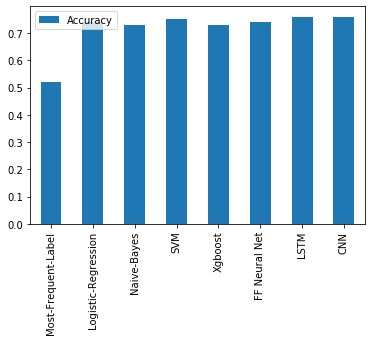

In [50]:
d = {"Most-Frequent-Label" :0.52, "Logistic-Regression" : 0.74, 'Naive-Bayes' : 0.73, 'SVM':0.75, "Xgboost" : 0.73, 'FF Neural Net' : 0.74, 'LSTM':0.76, 'CNN':0.76}
dataframe = pd.DataFrame(data = d, index =["Accuracy"])
result = dataframe.transpose()
result.plot.bar()
dataframe

### 4.2.1 Language Model
Implement language model to generate sarcasm headlines:

In [33]:
from collections import defaultdict
import numpy as np
import nltk
smoothing = 0.001
counts = defaultdict(lambda: defaultdict(lambda: smoothing))
corpus = [line.split() for line in sarcasm.headline.tolist()]

for sentence in corpus:
    tokens = ['*', '*'] + sentence + ['STOP']
    for u, v, w in nltk.ngrams(tokens, 3):
        counts[(u, v)][w] += 1

def logP(u, v, w):
    return np.log(counts[(u, v)][w]) - np.log(sum(counts[(u, v)].values()))

def sentence_logP(S):
    tokens = ['*', '*'] + S + ['STOP']
    return sum([logP(u, v, w) for u, v, w in nltk.ngrams(tokens, 3)])

In [34]:
def sample_next_word(u, v):
    keys, values = zip(*counts[(u, v)].items())
    values = np.array(values)
    values /= values.sum() # create probability distro
    sample = np.random.multinomial(1, values) # pick one position
    return keys[np.argmax(sample)]

def generate():
    result = ['*', '*']
    next_word = sample_next_word(result[-2], result[-1])
    result.append(next_word)
    while next_word != 'STOP':
        next_word = sample_next_word(result[-2], result[-1])
        result.append(next_word)

    return ' '.join(result[2:-1])

def get_perplexity(corpus):
    """
    perpelexity = 2^entropy(X)
    entropy = -sum(p(x)*log(p(x)))
    """
    total = 0
    for i in range(len(corpus)):
        log_p_x = sentence_logP(corpus[i])
        p_x = np.exp(log_p_x)
        total += p_x*log_p_x
    entropy = - total
    return 2**entropy

In [35]:
generate()

'john kerry leads prisoner uprising in siberian labor camp'

In [37]:
## Calculate perplexity
lang_model_perplexity = get_perplexity([generate().split() for i in range(10000)])
lang_model_perplexity

6.690054236445242

In [ ]:
## Check if some of the generated headlines are in the original ones
print(sarcasm["headline"].str.contains("dog can't believe he left consulate").any())
print(sarcasm["headline"].str.contains("deceased souls backed up at tall building thinking about, you know").any())
print(sarcasm["headline"].str.contains("sighing trump sexual assault has cooled down").any())
print(sarcasm["headline"].str.contains("matt lauer returns to stage for humans").any())

### 4.2.2 Neural language model
Preprocessing : each sentence is split in [sequence of words] [next word] for every possible combination.<br/>
The label ([next word]) is then encoded as a one hot vector (size = number of unique words in the train set) while the sentence is encoded with numbers as we did previously.<br/>
This allows the model to output the distribution of [next word] given [sequence of words] vie a softmax layer <br/>
To make the prediction, I sample from this distribution adn add it to the sequence of prediction and make the following predictions on this new sequence

In [101]:
corpus = [line.split() for line in sarcasm.headline.tolist()]

X_train = []
y_train = []
for sentence in corpus[:2000]:
    #include start and stop in the sentence
    tokens =  sentence 
    for i in range (len(tokens)-1) :
        X = tokens[:i]
        y = tokens[i+1]
        X_train.append(X)
        y_train.append(y)

y_train = np.array(y_train)
X_train = np.array(X_train)

In [102]:
vocab_size = len(np.unique(y_train))

one_hot = OneHotEncoder()
y_train_one_hot = one_hot.fit_transform(y_train.reshape(-1, 1))


wordset = set()
for words in X_train:
    wordset.update(set(words))

# map words and tags into ints
PAD = '-PAD-'
UNK = '-UNK-'
word2int = {word: i + 2 for i, word in enumerate(sorted(wordset))}
word2int[PAD] = 0  # special token for padding
word2int[UNK] = 1  # special token for unknown words

In [103]:
def convert2ints(instances):
    result = []
    for words in instances:
        # replace words with int, 1 for unknown words
        word_ints = [word2int.get(word, 1) for word in words]
        # replace tags with int
        result.append(word_ints)
    return result 

def convert2int(text):
    result = []
    # replace words with int, 1 for unknown words
    word_ints = [word2int.get(word, 1) for word in text]
    # replace tags with int
    result.append(word_ints)
    return result


train_instances_int = convert2ints(X_train)
# test_instances_int = convert2ints(test_instances)

train_sentences = pad_sequences(train_instances_int, maxlen=9, padding='post')
print(train_sentences[5])


#np.random.seed(42)
#from keras.optimizers import RMSprop
#model_seq = Sequential()
#model_seq.add(InputLayer(input_shape=(9, ), name="word_IDs"))
##model_seq.add(Embedding(len(word2int), 128, mask_zero=True, name='embeddings'))
#model_seq.add(Bidirectional(LSTM(units=256, return_sequences=False), name="Bi-LSTM"))
#model_seq.add(Dense(256, name = 'fully_connected1', activation = 'relu'))
#model_seq.add(Dropout(0.2, name='dropout'))
#model_seq.add(Dense(vocab_size, activation = 'softmax', name='output'))
#model_seq.summary()

batch_size = 32
epochs = 45

#model_seq.compile(loss='binary_crossentropy',
 #             optimizer=RMSprop(),
  #            metrics=['accuracy']
   #          )
#history = model_seq.fit(train_sentences, y_train_one_hot,
 #                   batch_size=batch_size,
  #                  epochs=epochs,
   #                 verbose=1,
    #                )

[5588 4855 5850 1847 1251    0    0    0    0]


In [104]:
filename = 'BiLSTM_language_model.sav'
model_seq = pickle.load(open(filename, 'rb'))

/home/hugopao/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/hugopao/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [105]:
def generate(text):
    liste = convert2int(text)
    train_sentences = pad_sequences(liste, maxlen=9, padding='post')
    a = np.random.choice(np.array([a for a in range(vocab_size)]), size = 1, p = np.transpose(model_seq.predict(train_sentences)[0]))
    return np.unique(y_train)[a[0]]

def run(text, sentence_length):
    texte = [text]
    for i in range (sentence_length):
        t = generate(texte)
        texte.append(t)
    return (' '.join(texte))

In [106]:
run("", 7)

' can tell lee out hand gets post'

In [107]:
get_perplexity([run("", 7).split() for i in range(10000)])

1.0012056270098542

##  Comparison between neural language model and probabilistic one

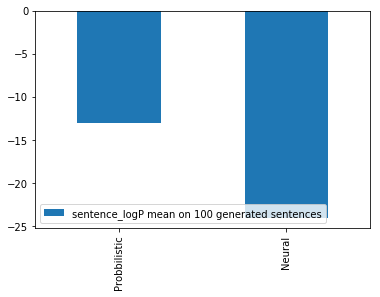

In [10]:
df = pd.DataFrame(data = np.array([-13,-24]), index = ["Probbilistic",'Neural'], columns = ['sentence_logP mean on 100 generated sentences'])
df.plot.bar()
#this comes from the sentence lopP mean on 100 generated sentences by both models

## BONUS
Having build a decent sarcasm predictor, we are  interested in finding out: How sarcastic are newspapers? 
For this, we have looked at a couple of datasets.

First, we score the NYT. This is a dataset obtained via the NYT API from 10/2019 to 02/2020 and includes headlines. 
The code related to the NYT scraper can be found in Konrad Eilers’ midterm project.

Second, we look at various news outlets via the News Aggregator Dataset from Kaggle (https://www.kaggle.com/uciml/news-aggregator-dataset).
This dataset contains headlines from more than 10k unique publishers scraped between May 2014 and August 2014.
Here, we only take a small subsample of 10 publishers.

Lastly, we look at a Clickhole dataset. This dataset is part of a Kaggle click-bait dataset (https://www.kaggle.com/ad6398/aossie-click-bait-dataset/version/2#clickhole.json) and includes headlines from Clickhole, a satire outlet. Unfortunately, it is unclear from when this dataset was taken.

All the sarcasm score are done with Logistic-Regression since as we have seen it performes well on predicting sarcasm and it is fast to run.

## Scoring New York Times

In [99]:
# Import data set 
nyt = pd.read_csv("nyt_data.csv")
headlines = nyt.the_headline
# Apply preprocessing
headlines = headlines.apply(preprocessing)
# Apply transformation
nyt_vectorized = vectorizer.transform(headlines.tolist())
# Score with Logistic-Regression
score_nyt = {}
score_nyt['New York Times'] = np.mean(classifier.predict(nyt_vectorized))
df_nyt = pd.DataFrame(data = score_nyt.values(), index = score_nyt.keys()).rename({0:'sarcasm_score'},axis = 1)
df_nyt

,sarcasm_score
New York Times,0.121545


## Scoring 10 publisher from News Aggregator Dataset

In [64]:
# Import data set 
news = pd.read_csv('uci-news-aggregator.csv')
news = news[["TITLE", "PUBLISHER", 'CATEGORY']]
news = news[news["PUBLISHER"].isin(np.array(news.PUBLISHER.value_counts().index[:10]))]
# Apply preprocessing
news["cleaned"] = news.TITLE.apply(preprocessing)
#news.to_csv("news_cleaned.csv")

In [100]:
# Import cleaned data set
news = pd.read_csv("news_cleaned.csv")
news = news.dropna()
# Apply transformation
news_vectorized = vectorizer.transform(news.cleaned.tolist())
# Predict the scores with Logistic Regression
news["score"] = classifier.predict(news_vectorized)

score_publisher = {}
for publisher in list(news.PUBLISHER.value_counts().index[:10]):
    score_publisher[publisher] = np.mean(news[news["PUBLISHER"] == publisher]['score'])

df_publisher = pd.DataFrame(data = score_publisher.values(), index = score_publisher.keys()).rename({0:'sarcasm_score'},axis = 1)
df_publisher

,sarcasm_score
Reuters,0.395090
Huffington Post,0.198494
Daily Mail,0.410040
Businessweek,0.182675
Contactmusic.com,0.188501
Examiner.com,0.311143
NASDAQ,0.285573
GlobalPost,0.409736
Los Angeles Times,0.322482
RTT News,0.268502


## Scoring Clickhole

In [101]:
import json
# Import data set
json_file_path = 'clickhole.json'
with open(json_file_path, 'r') as j:
     contents = json.loads(j.read())
        
clickhole = [contents[i]['article_title'] for i in range(len(contents))]

# Apply transformation
clickhole_v = vectorizer.transform(clickhole)
# Score with Logistic-Regression
score_Clickhole = {}
score_Clickhole['Clickhole'] = np.mean(classifier.predict(clickhole_v))
df_Clickhole = pd.DataFrame(data = score_Clickhole.values(), index = score_Clickhole.keys()).rename({0:'sarcasm_score'},axis = 1)
df_Clickhole

,sarcasm_score
Clickhole,0.740402


## Plot sarcasm scores

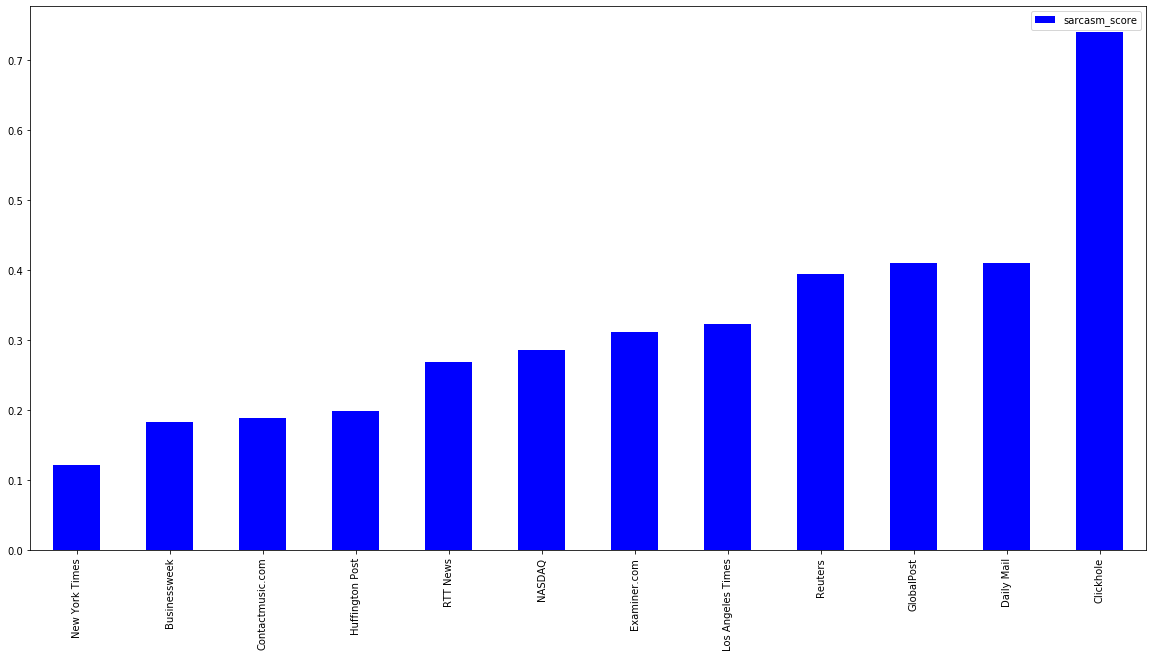

In [102]:
dataframe = df_nyt.append(df_publisher.append(df_Clickhole))
dataframe.sort_values("sarcasm_score").plot.bar(figsize = (20,10), color = 'b')

**Results**: we see that our classifier gets it approximately right. It makes perfect sense that the NYT has a low sarcasm score, while the sarcastic newspaper outlet Clickhole scores highest. However, we believe that our classifier predicts too many false positives. We do not think that 40% of L.A. Times news articles can be classified as sarcastic.